## introduction
### problem statement
Every day always more people experience the opportunity of training overywhere: outdoor on a park, in a garage, in our bedroom etc. Anyway this possibility of freedom led to a great issue commont to every uncommon athlets: the lack of feedbacks.
infact, while in a gym is easy receive a examination on own exercise esecution, by a trainer or by another athlet, on own bedroom we don't have this possibility. lack of feedback on exercise esecution led to learn improper esecutin, bring to weak performances, injuries etc

### state of art 
to evaluete own proper execution, athlets sometimes use to record their performarce in order to self esaminate them and find what is wrong. Anyway this process is tedios becouse it involve the need to find a good place to put the smartphone,record the clip, skip all the preparation of exercise, find the most significative point on the esecution, examinate them and finaly understaining whats wrong for correcting mistakes on the next repetition.
Do this proces for every rep, for every exercise, in time with rest time (usualy in the order of 1 minute), can be annoing and most athlets preferes to not be distracted and keep attention on their work out.

### proposed solution 
my idea is to make all this process agile for the atlets, developing a computer vision pipeline that is able  to take the recordered clip, extrapolate the most important keyframe for the athlets, discard all the unnecessary moment to be keep user attention on the most important moment and give to final user a edited clipp to fast evaluate own performances


# First part: Deep Learning

In [1]:
import numpy as np
import torch
import pytorch_lightning as pl

from torchvision import datasets
import matplotlib.pyplot as plt
import flowiz as fz

from dataset import  FlowDataModule
from models.flowNetS import FlowNetS
from models.raft import RAFT

from utilities.videoUtilities import extract_frames, saveVideo
from utilities.flowUtilities import computeFlow, flowVideo
from utilities.keyFramesUtilities import find_center_of_gravity, save_key_frames
from utilities.signalUtilities import  moving_average, findKeyPoints

/home/fi/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/fi/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


# datasets

### visualize the dataset


let's visualize how torch vison dataset FlyingChairs works

In [2]:
loadedDataset= datasets.Sintel(root='./dataset',
                              split = "train", 
                              #transforms = dataModulo.dataset_transformation,
                              pass_name = "clean"
                                )

dataset/Sintel/training/clean


image1 in dataset has shape: (436, 1024, 3)
image2 in dataset has shape: (436, 1024, 3)
flow image in dataset has shape: (2, 436, 1024)
flow image in dataset has this new shape: (436, 1024, 2)


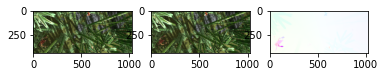

In [3]:
"""
dataset gives back triplets [image1,image2, targetFlow]
"""

triplet=loadedDataset[100]
img1,img2,flow= triplet

img1=np.asarray(img1)
img2=np.asarray(img2)

print (f"image1 in dataset has shape: {img1.shape}")
print (f"image2 in dataset has shape: {img2.shape}")

print (f"flow image in dataset has shape: {flow.shape}")
flow=np.transpose (flow,(1,2,0))
print (f"flow image in dataset has this new shape: {flow.shape}")

flow=fz.convert_from_flow(flow) 

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(flow)



## model training

In [4]:
save = torch.load("./models/checkpoint/flownets.pth.tar.pth")#["state_dict"]
model  = RAFT(version="large")
data=FlowDataModule(batch_size =1, workers=32,selected_dataset ="Sintel")
trainer = pl.Trainer(gpus=[0], 
                     max_epochs=20,             
                     auto_lr_find=False, 
                     auto_scale_batch_size=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
#trainer.fit(model,data )
#trainer.test(model, data)

# Second part: Computing Pipeline

In [6]:
device = torch.device("cuda:0")
model  = RAFT()
model.to(device)
video_path= "./input_video/pullup.mp4"
temp_extracted_frames="./temp/Frames/"
temp_processed_flow_frames="./temp/processedFloFrames/"

In [7]:
# fps=30
# fps=int(extract_frames(video_path))
# flow_video_direct(
#     path=temp_extracted_frames,
#     model=model,
#     device=device)
# saveVideo(temp_processed_flow_frames,"pippo", fps=fps)
   

In [8]:
# 3B- Find miving cordinates of center of gravity of our athlet
x,y=find_center_of_gravity(temp_processed_flow_frames)  
#saveVideo(comp,"PullUp_mass",bw=True)

100%|██████████| 1032/1032 [00:02<00:00, 450.21it/s]


## SIGNAL ANALISYS

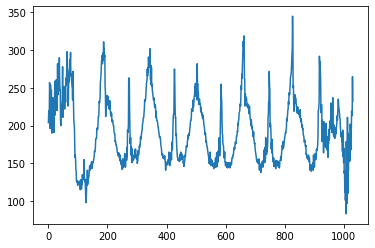

In [10]:
fig, ax = plt.subplots()
ax.plot(y)
plt.show()

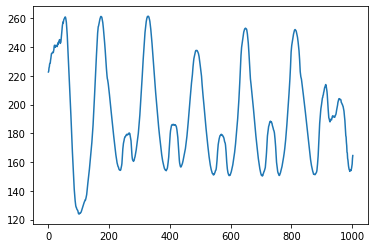

In [11]:
# 2- mobile average
#K=[0.25,0.25,0.25,0.25]


#avg=np.convolve(K,y)
avg=moving_average(y,k=30)
fig, ax = plt.subplots()
ax.plot(avg)
plt.show()

222.30333333333334


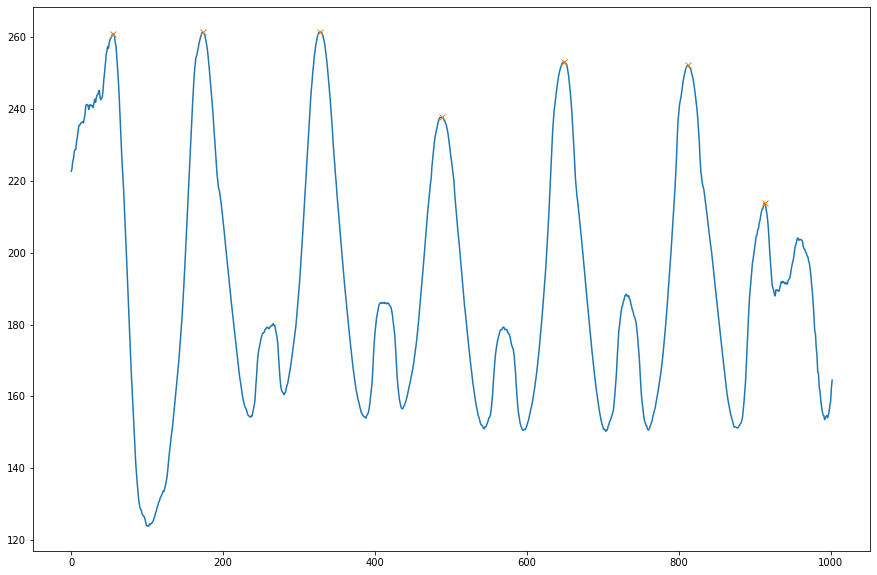

In [14]:
# 3- find peacks positive
peaks= findKeyPoints(avg)


np.diff(peaks)
plt.figure(figsize=(15,10))
plt.plot(avg)
plt.plot(peaks, avg[peaks], "x")
plt.show()


In [13]:
save_key_frames(
    keyFramesList=peaks, 
    frames_path=temp_extracted_frames,
    threshold=12, 
    near=5, 
    slowmotion=2, 
    speedUp=4, 
    title="final.avi")
#saveVideo(video,"video_allenamento_pullup", frames_rate=60)

[ 55 173 328 488 649 812 913]


100%|██████████| 1033/1033 [00:44<00:00, 22.98it/s]
